In [1]:
%matplotlib inline

# Entrenamiento 01

--------------

## Carga de librerías

In [2]:
import torch
import torchvision
import os
import pandas as pd
from skimage import io
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import random
from fastprogress import master_bar, progress_bar
import numpy as np

In [3]:
torch.__version__

'1.9.0'

--------------

In [4]:
SUBSET = 1
PATH = '../data'
BATCH_SIZE = 64
TEST_BATCH_SIZE = 200
IMAGES_224 = 1
if IMAGES_224:
    IMAGE_SIZE = (224, 224, 3)
else:
    IMAGE_SIZE = (224, 224, 3)
EPOCHS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [5]:
os.listdir(PATH)

['jpeg',
 'jpeg224',
 'sample_submission.csv',
 'subset.csv',
 'test.csv',
 'train.csv',
 'train_split.csv',
 'val_split.csv']

In [6]:
if SUBSET:
    train = pd.read_csv(f'{PATH}/subset.csv')
else:
    train = pd.read_csv(f'{PATH}/train_split.csv')

val = pd.read_csv(f'{PATH}/val_split.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train.shape, val.shape, test.shape

((2220, 8), (10932, 8), (10982, 5))

In [7]:
if IMAGES_224:
    train['path'] = [f'{PATH}/jpeg224/train/{img}.jpg' for img in train['image_name']]
    val['path'] = [f'{PATH}/jpeg224/train/{img}.jpg' for img in val['image_name']]
    test['path'] = [f'{PATH}/jpeg224/test/{img}.jpg' for img in test['image_name']]
else:
    train['path'] = [f'{PATH}/jpeg/train/{img}.jpg' for img in train['image_name']]
    val['path'] = [f'{PATH}/jpeg/train/{img}.jpg' for img in val['image_name']]
    test['path'] = [f'{PATH}/jpeg/test/{img}.jpg' for img in test['image_name']]

In [8]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path
0,ISIC_0533349,IP_5208504,female,45.0,lower extremity,unknown,benign,0,../data/jpeg224/train/ISIC_0533349.jpg
1,ISIC_8814612,IP_0414408,male,50.0,torso,unknown,benign,0,../data/jpeg224/train/ISIC_8814612.jpg
2,ISIC_6515241,IP_6245507,male,45.0,lower extremity,unknown,benign,0,../data/jpeg224/train/ISIC_6515241.jpg
3,ISIC_5075261,IP_2117218,male,40.0,upper extremity,unknown,benign,0,../data/jpeg224/train/ISIC_5075261.jpg
4,ISIC_2624460,IP_1969685,male,50.0,torso,unknown,benign,0,../data/jpeg224/train/ISIC_2624460.jpg


In [9]:
val.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path
0,ISIC_3141629,IP_2412574,male,70.0,torso,unknown,benign,0,../data/jpeg224/train/ISIC_3141629.jpg
1,ISIC_3184390,IP_3511494,male,45.0,upper extremity,unknown,benign,0,../data/jpeg224/train/ISIC_3184390.jpg
2,ISIC_9750885,IP_7121757,female,35.0,upper extremity,unknown,benign,0,../data/jpeg224/train/ISIC_9750885.jpg
3,ISIC_8330906,IP_8091497,male,45.0,torso,unknown,benign,0,../data/jpeg224/train/ISIC_8330906.jpg
4,ISIC_7746898,IP_9879000,male,30.0,lower extremity,unknown,benign,0,../data/jpeg224/train/ISIC_7746898.jpg


In [10]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,path
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../data/jpeg224/test/ISIC_0052060.jpg
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../data/jpeg224/test/ISIC_0052349.jpg
2,ISIC_0058510,IP_7960270,female,55.0,torso,../data/jpeg224/test/ISIC_0058510.jpg
3,ISIC_0073313,IP_6375035,female,50.0,torso,../data/jpeg224/test/ISIC_0073313.jpg
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,../data/jpeg224/test/ISIC_0073502.jpg


--------------

## Dataset y Dataloader

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, train=True):
        self.images = images
        self.labels = labels
        self.train = train

    def __len__(self):
        return len(self.images)

    def load_img(slef, img):
        return io.imread(img)

    def __getitem__(self, idx):
        img = self.load_img(self.images[idx])
        img = torch.from_numpy(img)

        if self.train:
            label = torch.tensor([self.labels[idx]]).float()
            return img, label
        else:
            return img

In [12]:
dataset = {
    'train': Dataset(train['path'], train['target']),
    'val': Dataset(val['path'], val['target'])
}

<function matplotlib.pyplot.show(close=None, block=None)>

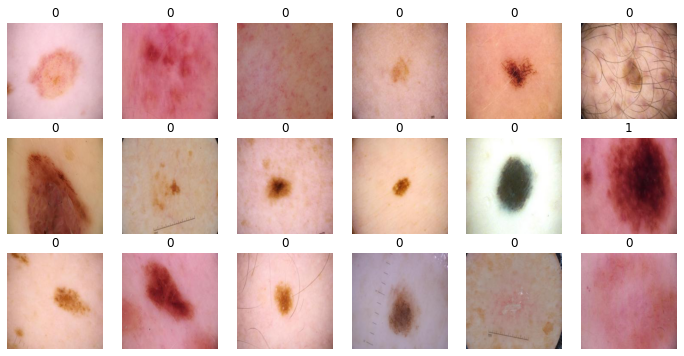

In [13]:
row, col = 3, 6
fig = plt.figure(figsize=(2*col, 2*row))
for r in range(row):
    for c in range(col):
        plt.subplot(row, col, r*col+c+1)
        idx = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][idx]
        plt.imshow(img)
        plt.axis(False)
        plt.title(int(label.item()))

plt.show

In [14]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE)
}

In [15]:
imgs, labels = next(iter(dataloader['train']))

imgs.shape, labels.shape

(torch.Size([64, 224, 224, 3]), torch.Size([64, 1]))

In [16]:
test_dataset = Dataset(test['path'], train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

In [17]:
imgs = next(iter(test_dataloader))

imgs.shape

torch.Size([200, 224, 224, 3])

--------------

## Network

In [18]:
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True)
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.encoder.fc = torch.nn.Linear(2048, 1)

    def forward(self, x):
        B, H, W, C = x.shape
        x = (x/255).float().view(B, C, H, W)
        y = self.encoder(x)
        return y

In [19]:
model = Net()

output = model(torch.rand(BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))
output.shape

C:\Users\mfnunez\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([64, 1])

In [20]:
net = Net()
net.to(DEVICE)

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

--------------

## Entrenamiento

In [21]:
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()

    labels = labels.numpy()

    auc = roc_auc_score(labels, outputs)

    return auc

In [23]:
# EPOCHS = 3
stop_at_validation_steps = False
validation_steps = 10

mb = master_bar(range(EPOCHS))

best_auc = 0

for epoch in mb:

    train_loss = []
    net.train()
    for batch in progress_bar(dataloader['train'], parent=mb):
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        y = net(imgs)

        optimizer.zero_grad()
        loss = criterion(y, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        mb.child.comment = f'loss {np.mean(train_loss):.5f}'
    

    val_loss = []
    net.eval()
    val_step = 0
    val_y = torch.tensor([])
    val_lables = torch.tensor([])
    with torch.no_grad():
        for batch in progress_bar(dataloader['val'], parent=mb):
            imgs, labels = batch
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            y = net(imgs)

            loss = criterion(y, labels)
            val_loss.append(loss.item())

            mb.child.comment = f'val loss {np.mean(val_loss):.5f}'

            val_y = torch.cat([val_y, y.cpu()])
            val_lables = torch.cat([val_lables, labels.cpu()])

            val_step += 1
            if stop_at_validation_steps:
                if val_step >= validation_steps:
                    break

    auc = AUC(val_y, val_lables)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, 'model.pth')
        print(f'best model {auc:.5f} at epoch {epoch}/{EPOCHS}')

    mb.write(f'Epoch {epoch+1}/{EPOCHS}: loss {np.mean(train_loss):.5f},  val_loss {np.mean(val_loss):.5f}, auc {auc:.5f}')



best model 0.91097 at epoch 0/10
best model 0.91536 at epoch 1/10
best model 0.91802 at epoch 2/10
best model 0.93261 at epoch 3/10
best model 0.93529 at epoch 4/10
best model 0.93909 at epoch 5/10
best model 0.94378 at epoch 6/10
best model 0.94911 at epoch 7/10
best model 0.95033 at epoch 8/10
best model 0.95656 at epoch 9/10


--------------

## Evaluación

In [24]:
model = torch.load('model.pth')
model.to(DEVICE);

In [25]:
preds = torch.tensor([]).to(DEVICE)
with torch.no_grad():
    for batch in progress_bar(test_dataloader):
        imgs = batch
        imgs = imgs.to(DEVICE)
        y = model(imgs)
        y = torch.sigmoid(y)
        preds = torch.cat([preds, y.view(-1)])

In [26]:
preds

tensor([1.7802e-03, 2.2284e-04, 2.8323e-03,  ..., 4.9937e-02, 5.9700e-03,
        2.5011e-01], device='cuda:0')

--------------

## Submision

In [27]:
submision = pd.DataFrame({'image_name': test['image_name'].values, 'target': preds.cpu().numpy()})

submision.head()

,image_name,target
0,ISIC_0052060,0.001780
1,ISIC_0052349,0.000223
2,ISIC_0058510,0.002832
3,ISIC_0073313,0.002894
4,ISIC_0073502,0.094081


In [ ]:
submision.to_csv('submision.csv', index=False)